# Getting Started

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

!pip install pyyaml h5py
!pip install impyute
!pip install catboost
import sys
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings(action='ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
data = pd.read_csv("/content/MagicBricks.csv")
data

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,Rohini Sector 25,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,NaN
1,750.0,2,2.0,Semi-Furnished,"J R Designers Floors, Rohini Sector 24",1.0,5000000,Ready_to_move,New_Property,Apartment,6667.0
2,950.0,2,2.0,Furnished,"Citizen Apartment, Rohini Sector 13",1.0,15500000,Ready_to_move,Resale,Apartment,6667.0
3,600.0,2,2.0,Semi-Furnished,Rohini Sector 24,1.0,4200000,Ready_to_move,Resale,Builder_Floor,6667.0
4,650.0,2,2.0,Semi-Furnished,Rohini Sector 24 carpet area 650 sqft status R...,1.0,6200000,Ready_to_move,New_Property,Builder_Floor,6667.0
...,...,...,...,...,...,...,...,...,...,...,...
1254,4118.0,4,5.0,Unfurnished,Chittaranjan Park,3.0,55000000,Ready_to_move,New_Property,Builder_Floor,12916.0
1255,1050.0,3,2.0,Semi-Furnished,Chittaranjan Park,3.0,12500000,Ready_to_move,Resale,Builder_Floor,12916.0
1256,875.0,3,3.0,Semi-Furnished,Chittaranjan Park,3.0,17500000,Ready_to_move,New_Property,Builder_Floor,12916.0
1257,990.0,2,2.0,Unfurnished,Chittaranjan Park Block A,1.0,11500000,Ready_to_move,Resale,Builder_Floor,12916.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Area         1259 non-null   float64
 1   BHK          1259 non-null   int64  
 2   Bathroom     1257 non-null   float64
 3   Furnishing   1254 non-null   object 
 4   Locality     1259 non-null   object 
 5   Parking      1226 non-null   float64
 6   Price        1259 non-null   int64  
 7   Status       1259 non-null   object 
 8   Transaction  1259 non-null   object 
 9   Type         1254 non-null   object 
 10  Per_Sqft     1018 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 108.3+ KB


In [4]:
#checking for null values
data.isnull().sum()

Area             0
BHK              0
Bathroom         2
Furnishing       5
Locality         0
Parking         33
Price            0
Status           0
Transaction      0
Type             5
Per_Sqft       241
dtype: int64

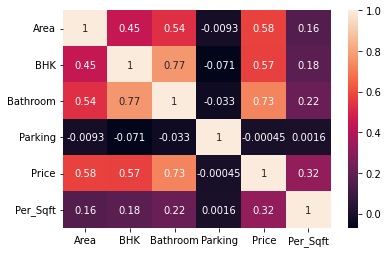

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(data.corr(method='pearson'),annot=True)
plt.show()
# print(data.corr(method='pearson'))

In [6]:
def onehot_encode(df, column, rename=False):
    df = df.copy()
    if rename == True:
        df[column] = df[column].replace({x: i for i, x in enumerate(df[column].unique())})
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [7]:
 x=data.copy()
    
x.drop(columns='Locality',axis=1,inplace=True)

    # Fill missing values
for column in ['Bathroom', 'Parking', 'Type']:
    x[column] = x[column].fillna(x[column].mode()[0])

# Binary encoding
x['Status'] = x['Status'].replace({
    'Almost_ready': 0,
    'Ready_to_move': 1
})
x['Transaction'] = x['Transaction'].replace({
    'New_Property': 0,
    'Resale': 1
})
x['Type'] = x['Type'].replace({
    'Builder_Floor': 0,
    'Apartment': 1
})
x = onehot_encode(x, column='Furnishing', rename=False)

missing_target_rows=x.loc[x['Per_Sqft'].isnull(),:].index
# calculate the KNN imputation
imputed_training=fast_knn(x.values, k=30)
to_fill_val=[]
for index in missing_target_rows:
    to_fill_val.append(np.float(round(imputed_training[index][8])))

to_fill_dic={ind:val for ind,val in zip(missing_target_rows,to_fill_val)}
x['Per_Sqft'].fillna(to_fill_dic,axis=0,inplace=True)


# Split df into X and y
y = x['Price']
X = x.drop('Price', axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [8]:
a,b,c,d=train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [9]:
b


,Area,BHK,Bathroom,Parking,Status,Transaction,Type,Per_Sqft,Furnishing_Furnished,Furnishing_Semi-Furnished,Furnishing_Unfurnished
972,1300.0,3,3.0,1.0,1,1,1,15174.0,1,0,0
719,1500.0,3,2.0,1.0,1,1,0,15563.0,0,0,0
979,780.0,2,2.0,1.0,1,1,1,9655.0,0,1,0
550,1500.0,3,2.0,1.0,1,0,0,28846.0,0,1,0
512,2250.0,3,2.0,1.0,1,1,0,4444.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
821,1250.0,3,3.0,2.0,0,0,0,8060.0,0,0,1
1014,1260.0,3,2.0,1.0,1,1,0,5556.0,0,1,0
503,1100.0,2,2.0,1.0,1,1,1,30556.0,0,1,0
401,495.0,2,2.0,1.0,1,0,0,6111.0,0,1,0


In [10]:
d

972      9200000
719     13500000
979      7500000
550     28500000
512     10000000
          ...   
821      8500000
1014     7000000
503     15000000
401      2150000
1089    18800000
Name: Price, Length: 378, dtype: int64

In [11]:
models = {
    "                     Linear Regression": LinearRegression(),
    " Linear Regression (L2 Regularization)": Ridge(),
    " Linear Regression (L1 Regularization)": Lasso(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(),
    "                     Gradient Boosting": GradientBoostingRegressor(),
    "                               XGBoost": XGBRegressor(),
    "                              LightGBM": LGBMRegressor(),
    "                              CatBoost": CatBoostRegressor(verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                     Linear Regression trained.
 Linear Regression (L2 Regularization) trained.
 Linear Regression (L1 Regularization) trained.
                   K-Nearest Neighbors trained.
                        Neural Network trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                         Decision Tree trained.
                         Random Forest trained.
                     Gradient Boosting trained.
[21:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                               XGBoost trained.
                              LightGBM trained.
                              CatBoost trained.


In [12]:
scores=[]
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(X_test[X_train.columns], y_test)))
    scores.append(model.score(X_test, y_test))

                     Linear Regression R^2 Score: 0.61593
 Linear Regression (L2 Regularization) R^2 Score: 0.61586
 Linear Regression (L1 Regularization) R^2 Score: 0.61593
                   K-Nearest Neighbors R^2 Score: 0.71695
                        Neural Network R^2 Score: -0.62248
Support Vector Machine (Linear Kernel) R^2 Score: -0.62248
   Support Vector Machine (RBF Kernel) R^2 Score: -0.07453
                         Decision Tree R^2 Score: 0.68735
                         Random Forest R^2 Score: 0.85819
                     Gradient Boosting R^2 Score: 0.86464
                               XGBoost R^2 Score: 0.88208
                              LightGBM R^2 Score: 0.82286
                              CatBoost R^2 Score: 0.87339


In [13]:
best_model_ind=np.argmax(scores)
best_model= list(models.values())[best_model_ind]
best_model.save_model("model.json",)

In [14]:
import pickle
pickle_out=open('classifier.pkl','wb')
pickle.dump(best_model,pickle_out)
pickle_out.close()

In [16]:
pickle.dump(scaler,open('scaler.pkl','wb'))

In [17]:
from keras.models import Model, load_model

loaded_model=pickle.load(open('classifier.pkl','rb'))
type(loaded_model)

[21:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


xgboost.sklearn.XGBRegressor

In [18]:
labels=list(X.columns)
input_data=pd.DataFrame([[750.0, 2.0, 2.0, 1.0, 1, 0, 1, 6667.0, 1, 0, 0]],columns=labels)

In [21]:
cols_when_model_builds = loaded_model.get_booster().feature_names
input_data=pd.DataFrame(inp,columns=cols_when_model_builds)

NameError: ignored

In [22]:
input_data

,Area,BHK,Bathroom,Parking,Status,Transaction,Type,Per_Sqft,Furnishing_Furnished,Furnishing_Semi-Furnished,Furnishing_Unfurnished
0,750.0,2.0,2.0,1.0,1,0,1,6667.0,1,0,0


In [ ]:
loaded_model.predict(input_data)

In [ ]:
loaded_model.predict(input_data)

In [ ]:
X_test.iloc[0].shape

In [ ]:
cols_when_model_builds

In [ ]:
input_data